## Question Answering with a fine-tuned BERT on CoQA dataset

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install transformers

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer, AutoTokenizer
from transformers import AutoModel, AutoConfig, AutoModelForSequenceClassification, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import os
import torch
import numpy as np
import logging.config
from tqdm import tqdm
import matplotlib.pyplot as plt
# from dataset import load_dataset, visualize_dataset
import string
import copy
from re import sub
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'
from functools import partial
from time import sleep

from tqdm.notebook import tqdm_notebook
from tqdm.notebook import tnrange

import warnings
warnings.filterwarnings('ignore')

2023-05-08 13:47:41.564761: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 13:47:41.608290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 13:47:42.171857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from utils.config import get_arguments
args = get_arguments()
DEVICE = torch.device(args.gpu if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cuda


In [3]:
args.data_dir

'/home/siu856533724/code/source-code/Social-Networks/Trend-Prediction/DataSet/csv'

In [4]:
# from utils.dataset import get_dataset
# dataset = get_dataset(args.data_set, args.data_dir)
# df = dataset['dataset1'][0:1000]
# df.head()

In [5]:
from datasets import load_dataset
gemotion_data = load_dataset("go_emotions")
gemotion_data = gemotion_data.data
train, valid, test = gemotion_data["train"].to_pandas(), gemotion_data["validation"].to_pandas(), gemotion_data["test"].to_pandas()
# df = train #pd.concat([train, valid, test], axis=0)
# df.head()


No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/siu856533724/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
def one_hot_encoder(df):
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0]*28
        label_indices = df.iloc[i]["labels"]
        # print(label_indices)
        for index in label_indices:
            temp[index] = 1
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [7]:
train_ohe_labels = one_hot_encoder(train)
test_ohe_labels = one_hot_encoder(test)
valid_ohe_labels = one_hot_encoder(valid)
# df_ohe_labels.shape

100%|██████████| 5426/5426 [00:00<00:00, 40578.51it/s]


In [8]:
train = pd.concat([train, train_ohe_labels], axis=1)
test = pd.concat([test, test_ohe_labels], axis=1)
valid = pd.concat([valid, valid_ohe_labels], axis=1)

In [9]:
from utils.preprocessing import get_clean_dataset

# df_clean = get_clean_dataset(data_frame)
# counts = df['label'].value_counts()
# df = df[~df['label'].isin(counts[counts < 50].index)]

In [10]:
# category_list = df_clean.labels.unique()
# category_list = list(category_list)

In [11]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

# n_labels = len(mapping)

In [12]:
# class_names = []
# mapping = {}

# class_names = list(mapping.values())
# mapping = {}
# for i, name in enumerate(category_list):
#     mapping[name] = i

# print(mapping)
args.num_labels = len(mapping)

In [13]:
# data_frame = df_clean.loc[df_clean["labels"] != 'empty' ]
# data_frame['labels'] = data_frame['labels'].str.strip().map(mapping)

In [14]:
# output_path =  './outputs/{}_{}_{}_{}_{}.csv'.format(ckpt, NUM_EPOCHS , LOCAL_ITERS, BATCH_SIZE, NUM_CLIENTS)

In [15]:
# Get the lists of sentences and their labels.
# sentences = data_frame.text.values
# labels = data_frame.label.values
# labels = labels.astype('int64')

In [16]:
# from sklearn.utils import shuffle
# data_frame = shuffle(data_frame)
# train_size = 0.8
# validate_size = 0.1
# # Spliting the dataset into 3 parts Training, Test, and Validation
# train, valid, test = np.split(data_frame, [int(train_size * len(data_frame)), int((validate_size + train_size) * len(data_frame))])

In [17]:
print('Dataset information:')
print(f'Training data: {train.shape}')
print(f'Validation data: {valid.shape}')
print(f'Test data: {test.shape}')

# train = train.reset_index(drop=True)
# test = test.reset_index(drop=True)
# valid = test.reset_index(drop=True)

Dataset information:
Training data: (43410, 31)
Validation data: (5426, 31)
Test data: (5427, 31)


In [18]:
from transformers import AutoModel
import torch.nn as nn

class TextClassification(nn.Module):
    def __init__ (self, args):
        super(TextClassification, self).__init__()
        self.model = AutoModel.from_pretrained(args.model_ckpt)
        self.dropout = nn.Dropout(args.dropout)
        self.out = nn.Linear(768, args.num_labels)
        self.n_train_steps = args.train_steps
        self.step_scheduler_after = "batch"
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        pooledOut = self.model(input_ids=input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        bertOut = self.dropout(pooledOut[1])
        output = self.out(bertOut)
        
        return output

In [19]:
from utils.dataset import MyDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
def build_dataset(tokenizer, args):
    train_dataset = MyDataset(train.text.tolist(), train[range(args.num_labels)].values.tolist(), tokenizer, args.tokenizer_max_len)
    valid_dataset = MyDataset(valid.text.tolist(), valid[range(args.num_labels)].values.tolist(), tokenizer, args.tokenizer_max_len)
    test_dataset = MyDataset(test.text.tolist(), test[range(args.num_labels)].values.tolist(), tokenizer, args.tokenizer_max_len)
    return {"train": train_dataset, "test": test_dataset, "valid": valid_dataset}

def build_dataloader(train_dataset, valid_dataset, test_dataset, args):
    train_data_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_data_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=True, num_workers=1)
    test_data_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=1)
    return {"train": train_data_loader, "test": test_data_loader, "valid": valid_data_loader}

def ret_model(args):
    # model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, # Use the 12-layer BERT model, with an uncased vocab.
    #     num_labels = args.num_labels, # The number of output labels--2 for binary classification.
    #                     # You can increase this for multi-class tasks.   
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    #     ignore_mismatched_sizes=True
    #     )
    model = TextClassification(args=args)
    return model
            
def ret_tokenizer(args):
    tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt, do_lower_case=True)
    return tokenizer

In [20]:
from transformers import get_linear_schedule_with_warmup, AdamW

def ret_optimizer(model, args):
    # '''
    # Taken from Abhishek Thakur's Tez library example: 
    # https://github.com/abhishekkrthakur/tez/blob/main/examples/text_classification/binary.py
    # '''
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    opt = AdamW(optimizer_parameters, lr=args.lr)
    scheduler = get_linear_schedule_with_warmup(opt, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = args.total_steps)
    return {"optimizer": opt, "scheduler": scheduler}

In [21]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
import random
import numpy as np
from utils.train import model_train
from utils.eval import model_eval
from utils.common_functions import log_metrics1

def trainer(args):
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    all_train_loss = list()
    val_loss_min = np.Inf
    training_stats = []

    tokenizer = ret_tokenizer(args=args)
    dataset = build_dataset(tokenizer, args=args)
    dataloader = build_dataloader(dataset['train'], dataset['valid'], dataset['test'], args=args)
    args.train_steps = int(len(dataset['train']) / args.batch_size * 10) #(len(dataloader['train']) * args.epochs)
    model = ret_model(args=args)
    otpz = ret_optimizer(model, args=args)
    optimizer = otpz['optimizer']
    scheduler = otpz['scheduler']
    
    model.to(DEVICE)
    model = nn.DataParallel(model)

    #Train the model for given number of epochs
    for epoch in tnrange(args.epochs, desc="Model Training"):
        param, loss, _ = model_train(DEVICE, model, dataloader['train'], optimizer, scheduler)
        # model.load_state_dict(param)

        #Update the global model
        # global_model.load_state_dict(global_params)
        all_train_loss.append(loss)
        
        #Test the global model
        # val_acc, val_loss, val_auc = model_eval(DEVICE, global_model, validation_dataloader)
        # avg_val_accuracy, avg_val_loss, avg_val_auc = model_eval(device, model, validation_dataloader)
        eval_loss, preds, labels = model_eval(DEVICE, model, dataloader['valid'], args=args)

        avg_eval_loss = eval_loss / len(dataloader['valid'])
        auc_score = log_metrics1(preds, labels)["auc_micro"]

        # auc_score = log_metrics(preds, labels)["auc_micro"]
        # print("AUC score: ", auc_score)
        # all_val_loss.append(val_loss)
        
        print('Epoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val AUC: {:.8f}'\
            .format(epoch , args.epochs, loss, avg_eval_loss, auc_score))
        
        training_stats.append(
            {
                'Round': epoch + 1,
                'Train Loss': loss,
                # 'Valid. Acc1': score['acc1'],
                # 'Valid. Acc2': score['acc2'],
                'Valid. Loss': avg_eval_loss,
                'Valid. AUC': auc_score,
                # 'Valid. F1': score['f1'],
                # 'Valid. Precision': score['precision'],
                # 'Valid. Recall': score['recall']
            }
        )
        
        #if validation loss decreases, save the model
        if avg_eval_loss < val_loss_min:
            val_loss_min = avg_eval_loss
            # logger.info("Saving Model State")
            torch.save(model.state_dict(), "./models/" + args.model_ckpt + "_.sav")
            
    return training_stats

#load the best model from training
# global_model.load_state_dict(torch.load("./models/"+ DATASET + "_" + str(NUM_CLIENTS) + "_federated.sav"))
#test the model using test data

In [23]:
args.epochs = 10
training_stats = trainer(args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10, Train Loss: 0.70645063, Val Loss: 0.69877301, Val AUC: 0.61130173
Epoch: 1/10, Train Loss: 0.70659750, Val Loss: 0.69875247, Val AUC: 0.61130173
Epoch: 2/10, Train Loss: 0.70663853, Val Loss: 0.69879114, Val AUC: 0.61130173
Epoch: 3/10, Train Loss: 0.70662692, Val Loss: 0.69876248, Val AUC: 0.61130173
Epoch: 4/10, Train Loss: 0.70640547, Val Loss: 0.69875478, Val AUC: 0.61130173
Epoch: 5/10, Train Loss: 0.70660382, Val Loss: 0.69877517, Val AUC: 0.61130173
Epoch: 6/10, Train Loss: 0.70642444, Val Loss: 0.69875774, Val AUC: 0.61130173
Epoch: 7/10, Train Loss: 0.70666488, Val Loss: 0.69876124, Val AUC: 0.61130173
Epoch: 8/10, Train Loss: 0.70664077, Val Loss: 0.69876989, Val AUC: 0.61130173
Epoch: 9/10, Train Loss: 0.70644290, Val Loss: 0.69877110, Val AUC: 0.61130173


In [24]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Round')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Train Loss,Valid. Loss,Valid. AUC
Round,,,
1,0.706451,0.698773,0.611302
2,0.706597,0.698752,0.611302
3,0.706639,0.698791,0.611302
4,0.706627,0.698762,0.611302
5,0.706405,0.698755,0.611302
6,0.706604,0.698775,0.611302
7,0.706424,0.698758,0.611302
8,0.706665,0.698761,0.611302
9,0.706641,0.698770,0.611302


In [25]:
# df_stats.to_csv(output_path)

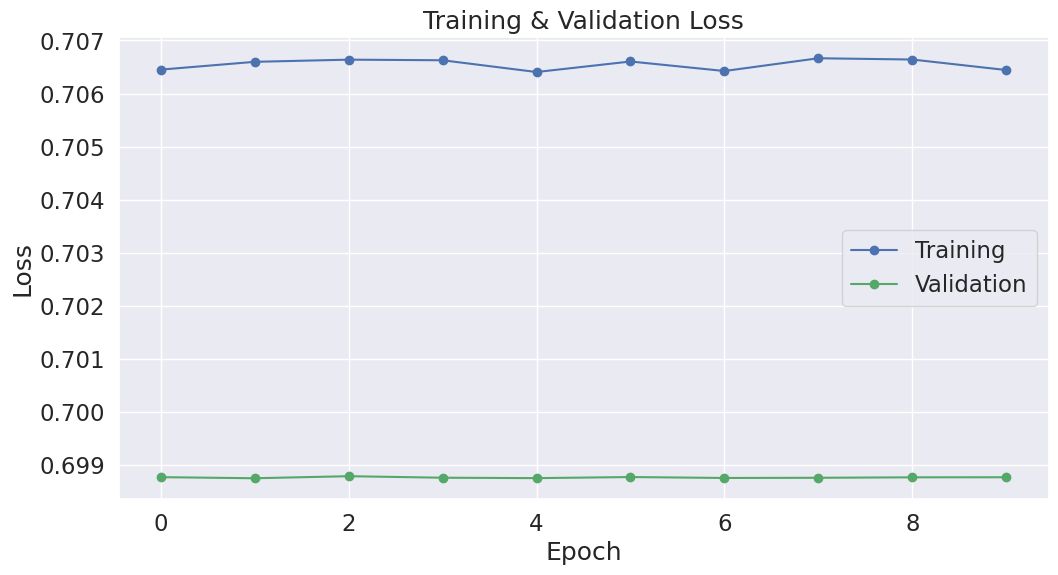

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

X = [i for i in range(args.epochs)]

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(X, df_stats['Train Loss'], 'b-o', label="Training")
plt.plot(X, df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.xticks(ls)

plt.show()

### Version checking

In [27]:
torch.__version__

'1.13.0+cu117'